---

<h1 style="text-align: center;font-size: 40px;">Cataract Prediction using vgg19</h1>

---

<h3>Dataset Information:</h3>
Ocular Disease Intelligent Recognition (ODIR) is a structured ophthalmic database of 5,000 patients with age, color fundus photographs from left and right eyes and doctors' diagnostic keywords from doctors.This dataset is meant to represent ‘‘real-life’’ set of patient information collected by Shanggong Medical Technology Co., Ltd. from different hospitals/medical centers in China. In these institutions, fundus images are captured by various cameras in the market, such as Canon, Zeiss and Kowa, resulting into varied image resolutions.Annotations were labeled by trained human readers with quality control management. They classify patient into eight labels including:

- Normal (N),
- Diabetes (D),
- Glaucoma (G),
- Cataract (C),
- Age related Macular Degeneration (A),
- Hypertension (H),
- Pathological Myopia (M),
- Other diseases/abnormalities (O)

- Here i'm going to make a model which is going to  predict an image is belongs to Normal or Cataract category!

In [89]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

os.environ['TF_MLIR_ENABLE'] = '1'
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [90]:
df = pd.read_csv("archive/full_df.csv")
df.head(3)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg


> <h3> Extracting Cataract & Normal information from the Dataset </h3>

In [91]:
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0

In [92]:
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

In [93]:
left_cataract = df.loc[(df.C ==1) & (df.left_cataract == 1)]["Left-Fundus"].values
left_cataract[:15]

array(['0_left.jpg', '81_left.jpg', '103_left.jpg', '119_left.jpg',
       '254_left.jpg', '294_left.jpg', '330_left.jpg', '448_left.jpg',
       '465_left.jpg', '477_left.jpg', '553_left.jpg', '560_left.jpg',
       '594_left.jpg', '611_left.jpg', '625_left.jpg'], dtype=object)

In [94]:
right_cataract = df.loc[(df.C ==1) & (df.right_cataract == 1)]["Right-Fundus"].values
right_cataract[:15]

array(['24_right.jpg', '81_right.jpg', '112_right.jpg', '188_right.jpg',
       '218_right.jpg', '345_right.jpg', '354_right.jpg', '477_right.jpg',
       '553_right.jpg', '560_right.jpg', '625_right.jpg', '726_right.jpg',
       '769_right.jpg', '949_right.jpg', '955_right.jpg'], dtype=object)

In [95]:
print("Number of images in left cataract: {}".format(len(left_cataract)))
print("Number of images in right cataract: {}".format(len(right_cataract)))

Number of images in left cataract: 304
Number of images in right cataract: 290


>Normal Images

In [96]:
left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250,random_state=42).values
right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250,random_state=42).values
right_normal[:15]

array(['2964_right.jpg', '680_right.jpg', '500_right.jpg',
       '2368_right.jpg', '2820_right.jpg', '2769_right.jpg',
       '2696_right.jpg', '2890_right.jpg', '940_right.jpg',
       '2553_right.jpg', '3371_right.jpg', '3042_right.jpg',
       '919_right.jpg', '3427_right.jpg', '379_right.jpg'], dtype=object)

In [97]:
cataract = np.concatenate((left_cataract,right_cataract),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)

In [98]:
print(len(cataract),len(normal))

594 500


><h3>Creating Dataset from images</h3>

In [99]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir = "archive/preprocessed_images/"
image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset
        

In [100]:
dataset = create_dataset(cataract,1)

 24%|██▍       | 144/594 [00:00<00:00, 476.82it/s][ WARN:0@2037.793] global loadsave.cpp:248 findDecoder imread_('archive/preprocessed_images/2244_left.jpg'): can't open/read file: check file path/integrity
[ WARN:0@2037.801] global loadsave.cpp:248 findDecoder imread_('archive/preprocessed_images/2251_left.jpg'): can't open/read file: check file path/integrity
100%|██████████| 594/594 [00:01<00:00, 555.10it/s]


In [101]:
len(dataset)

588

In [102]:
dataset = create_dataset(normal,0)

100%|██████████| 500/500 [00:01<00:00, 490.52it/s]


In [103]:
len(dataset)

1088

><h3>Let's see some images</h3>

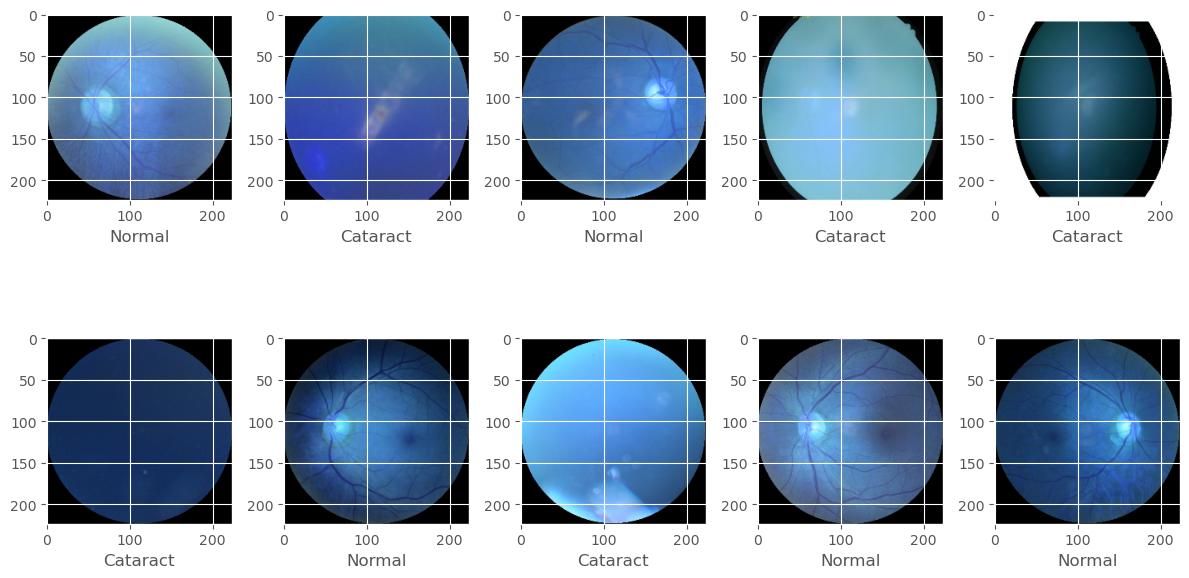

In [104]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()    

><h3>Dividing dataset into x(features) & y(target)</h3>

In [105]:
# x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
# y = np.array([i[1] for i in dataset])

# from sklearn.model_selection import train_test_split
# x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [106]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# 假设 x 和 y 是你的数据和标签
# 确保 x 和 y 是 NumPy 数组
x = np.array([i[0] for i in dataset]).reshape(-1, image_size, image_size, 3)
y = np.array([i[1] for i in dataset])

# 数据集划分
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# 将标签转换为独热编码
y_train = to_categorical(y_train, num_classes=8)
y_test = to_categorical(y_test, num_classes=8)

# 打印转换后的标签形状以验证
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (870, 8)
y_test shape: (218, 8)


In [107]:
np.isnan(x_train).any(), np.isnan(y_train).any()
np.isinf(x_train).any(), np.isinf(y_train).any()

(False, False)

# 数据增强


In [108]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(x_train)

# Creating Model-二分类问题

In [109]:
# from tensorflow.keras.applications.vgg19 import VGG19
# vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

# for layer in vgg.layers:
#     layer.trainable = False
    
# from tensorflow.keras import Sequential
# from tensorflow.keras.layers import Flatten,Dense
# model = Sequential()
# model.add(vgg)
# model.add(Flatten())
# model.add(Dense(1,activation="sigmoid"))

# model.summary()

In [110]:
# from tensorflow.keras.optimizers import Adam

# optimizer = Adam(learning_rate=0.001)
# model.compile(optimizer=optimizer,loss="binary_crossentropy",metrics=["accuracy"])

# from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
# checkpoint = ModelCheckpoint("vgg19.h5",monitor="val_accuracy",verbose=1,save_best_only=True,
#                              save_weights_only=False,period=1)
# earlystop = EarlyStopping(monitor="val_accuracy",patience=5,verbose=1)

In [111]:
# history = model.fit(x_train,y_train,batch_size=32,epochs=15,validation_data=(x_test,y_test),
#                     verbose=1,callbacks=[checkpoint,earlystop])

# history = model.fit(x_train,y_train,batch_size=16,epochs=15,validation_data=(x_test,y_test),
#                     verbose=1,callbacks=[checkpoint,earlystop])

# 模型设计-多分类问题

In [112]:
# 构建模型
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(8, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# 解冻 VGG19 的后几层以进行微调
for layer in base_model.layers[:15]:
    layer.trainable = False
for layer in base_model.layers[15:]:
    layer.trainable = True



from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# 编译模型
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# 设置学习率调节器
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

# 模型训练
history = model.fit(datagen.flow(x_train, y_train, batch_size=32), validation_data=(x_test,y_test),
                    epochs=50, callbacks=[reduce_lr])
# history = model.fit(x_train,y_train,batch_size=16,epochs=15,validation_data=(x_test,y_test),
#                     verbose=1,callbacks=[checkpoint,earlystop])

Epoch 1/50
28/28 [==============================] - 4s 136ms/step - loss: 2.0780 - accuracy: 0.4478 - val_loss: 2.0753 - val_accuracy: 0.5000
Epoch 2/50
28/28 [==============================] - 4s 134ms/step - loss: 2.0743 - accuracy: 0.4522 - val_loss: 2.0711 - val_accuracy: 0.5000
Epoch 3/50
28/28 [==============================] - 4s 135ms/step - loss: 2.0701 - accuracy: 0.4727 - val_loss: 2.0670 - val_accuracy: 0.5000
Epoch 4/50
28/28 [==============================] - 4s 135ms/step - loss: 2.0660 - accuracy: 0.5250 - val_loss: 2.0629 - val_accuracy: 0.5000
Epoch 5/50
28/28 [==============================] - 4s 137ms/step - loss: 2.0619 - accuracy: 0.5345 - val_loss: 2.0588 - val_accuracy: 0.5000
Epoch 6/50
28/28 [==============================] - 4s 136ms/step - loss: 2.0577 - accuracy: 0.5716 - val_loss: 2.0547 - val_accuracy: 0.5000
Epoch 7/50
28/28 [==============================] - 4s 137ms/step - loss: 2.0536 - accuracy: 0.5363 - val_loss: 2.0506 - val_accuracy: 0.5000
Epoch 

In [113]:
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)

print("Accuracy:",accuracy)

1/7 [===>..........................] - ETA: 0s - loss: 1.8833 - accuracy: 0.4688

7/7 [==============================] - 0s 7ms/step - loss: 1.8832 - accuracy: 0.5000
loss: 1.8831794261932373
Accuracy: 0.5


In [114]:
# from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
# y_pred = model.predict_classes(x_test)

# print(classification_report(y_test,y_pred))

# accuracy_score(y_test,y_pred)

# from mlxtend.plotting import plot_confusion_matrix
# cm = confusion_matrix(y_test,y_pred)
# plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names = ["Normal","Cataract"],
#                       show_normed = True);

Accuracy: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       109
           1       0.50      1.00      0.67       109

    accuracy                           0.50       218
   macro avg       0.25      0.50      0.33       218
weighted avg       0.25      0.50      0.33       218

Confusion Matrix:
 [[  0 109]
 [  0 109]]


/home/robot/miniconda3/envs/zbs/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/robot/miniconda3/envs/zbs/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/robot/miniconda3/envs/zbs/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(<Figure size 800x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

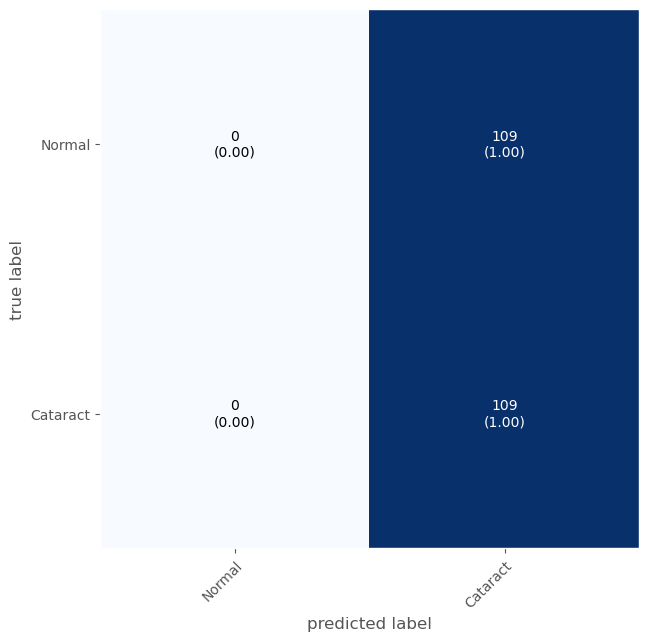

In [115]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np

# 获取预测结果
y_pred_prob = model.predict(x_test)

# 将预测结果转换为类别索引
y_pred = np.argmax(y_pred_prob, axis=1)

# 将独热编码的标签转换回原始标签
y_test_orig = np.argmax(y_test, axis=1)

# 计算准确率
accuracy = accuracy_score(y_test_orig, y_pred)
print("Accuracy:", accuracy)

# 打印分类报告
print(classification_report(y_test_orig, y_pred))

# 计算混淆矩阵
cm = confusion_matrix(y_test_orig, y_pred)
print("Confusion Matrix:\n", cm)

# 绘制混淆矩阵
from mlxtend.plotting import plot_confusion_matrix
plot_confusion_matrix(conf_mat=cm, figsize=(8, 7), class_names=["Normal", "Cataract"], show_normed=True)

><h3>Learning Curve</h3>

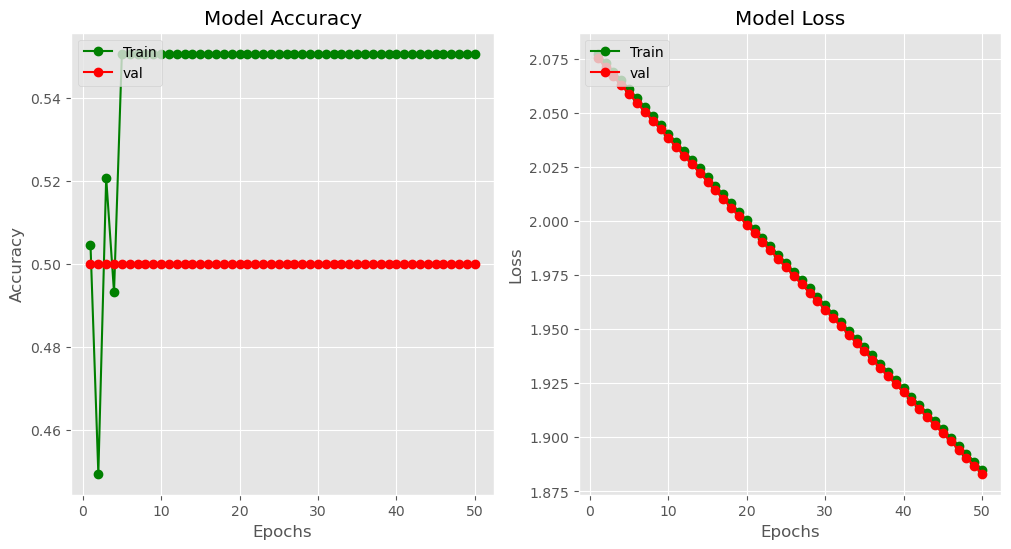

In [116]:
plt.style.use("ggplot")
fig = plt.figure(figsize=(12,6))
# epochs = range(1,16)
epochs = range(1, len(history.history["accuracy"]) + 1)

plt.subplot(1,2,1)
plt.plot(epochs,history.history["accuracy"],"go-")
plt.plot(epochs,history.history["val_accuracy"],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history.history["loss"],"go-")
plt.plot(epochs,history.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()

><h3>Prediction:</h3>

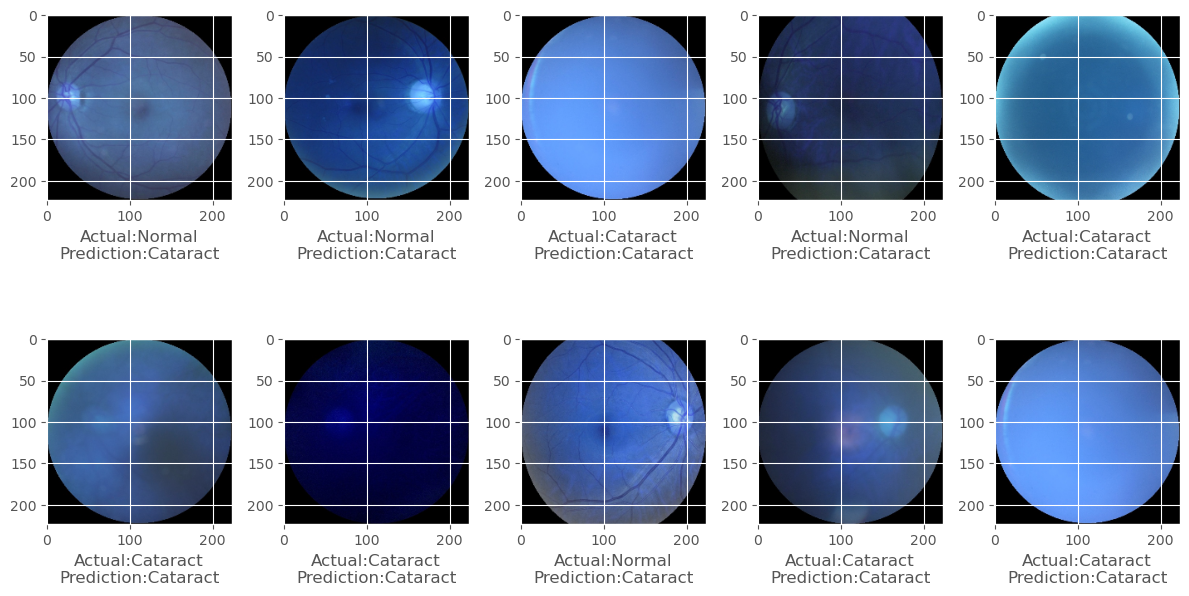

In [117]:
# 预测结果展示
plt.figure(figsize=(12, 7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test_orig[sample]
    pred_category = y_pred[sample]
    
    if category == 0:
        label = "Normal"
    else:
        label = "Cataract"
        
    if pred_category == 0:
        pred_label = "Normal"
    else:
        pred_label = "Cataract"
        
    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label, pred_label))
plt.tight_layout()
plt.show()

In [118]:
# plt.figure(figsize=(12,7))
# for i in range(10):
#     sample = random.choice(range(len(x_test)))
#     image = x_test[sample]
#     category = y_test[sample]
#     pred_category = y_pred[sample]
    
#     if category== 0:
#         label = "Normal"
#     else:
#         label = "Cataract"
        
#     if pred_category== 0:
#         pred_label = "Normal"
#     else:
#         pred_label = "Cataract"
        
#     plt.subplot(2,5,i+1)
#     plt.imshow(image)
#     plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
# plt.tight_layout() 

---

<h1 style="text-align: center;font-size: 20px;">Thanks for Reading!!</h1>

---